# EN3160 Assignment 3 on Neural Networks

Instructed by Dr. Ranga Rodrigo

Done by Jayakumar W.S. (210236P)

### Introduction

This assignment is focused on implementing neural networks for image classification. This is done by using:
1. Our own neural network implementation
2. An implementation of LeNet-5
3. An implementation of ResNet-18

### Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import gc

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataloading

In [ ]:
transform = transforms.Compose ([ transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5))])
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root= './data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root= './data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Device begin used : cuda


### Our own architecture

#### Define Network Parameters

In [89]:
Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5
# Initialize weights and biases
w = torch.randn(Din, K, device=device, dtype=torch.float, requires_grad=True) * std
b = torch.randn(K, device=device, dtype=torch.float, requires_grad=True)
# Hyperparameters
iterations = 20
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = [ ]

In [90]:
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1).to(device)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float().to(device)  # Convert labels to one-hot

        # Forward pass
        y_pred = x_train.mm(w) + b  # Output layer activation

        # Loss calculation (Mean Squared Error with regularization)
        loss = (1/Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * torch.sum(w ** 2)
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dw = x_train.t().mm(dy_pred) + reg * w
        db = dy_pred.sum(dim=0)

        # Parameter update
        w = w - lr * dw
        b = b - lr * db

    print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 20, Loss: 6.699454003088152
Epoch 2 / 20, Loss: 5.909720145656905
Epoch 3 / 20, Loss: 5.567146766208642
Epoch 4 / 20, Loss: 5.371137495004284
Epoch 5 / 20, Loss: 5.239274125486632
Epoch 6 / 20, Loss: 5.141399966854356
Epoch 7 / 20, Loss: 5.065108688840176
Epoch 8 / 20, Loss: 5.001932431243584
Epoch 9 / 20, Loss: 4.94949169824006
Epoch 10 / 20, Loss: 4.905234830622023
Epoch 11 / 20, Loss: 4.867476864343107
Epoch 12 / 20, Loss: 4.835044092653046
Epoch 13 / 20, Loss: 4.80636586169745
Epoch 14 / 20, Loss: 4.7824961197963525
Epoch 15 / 20, Loss: 4.759909802953631
Epoch 16 / 20, Loss: 4.741199179787858
Epoch 17 / 20, Loss: 4.724728078317429
Epoch 18 / 20, Loss: 4.709698528032309
Epoch 19 / 20, Loss: 4.696480659819229
Epoch 20 / 20, Loss: 4.684911614873816


In [91]:
del w, b, x_train, y_train_onehot, y_pred, loss, dy_pred, dw, db
gc.collect()
torch.cuda.empty_cache()

In [92]:
# This implementation is not efficient and is only for educational purposes. For real-world applications, use PyTorch's built-in functions and classes. This fails
# as memory usage increases with the number of iterations.

Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5
# Initialize weights and biases
w1 = torch.randn(Din, 100, device=device, requires_grad=True)
b1 = torch.zeros(100, device=device, requires_grad=True)
w2 = torch.randn(100, K, device=device, requires_grad=True)
b2 = torch.zeros(K, device=device, requires_grad=True)
# Hyperparameters
iterations = 20
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = [ ]

#### Training loop

In [93]:
for t in range(iterations) :
    running_loss = 0.0
    for i , data in enumerate(trainloader, 0) :
        # Get inputs and labe l s
        inputs , labels = data
        Ntr = inputs.shape[0] # Batch size
        x_train = inputs.view(Ntr, -1).to(device) # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float().to(device) # Convert labe l s to one=hot # Forward pass
        hidden = x_train.mm(w1) + b1
        y_pred = hidden.mm(w2) + b2
        # Loss calculation (Mean Squared Error with regularization)
        loss = (1/Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        loss_history.append(loss.item())
        running_loss += loss.item()
        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dhidden = dy_pred.mm(w2.t()) 
        dw2 = hidden.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)
        # Parameter update
        w2 = w2 - lr * dw2
        b2 = b2 - lr * db2
        w1 = w1 - lr * dw1
        b1 = b1 - lr * db1
    print(f"Epoch {t+1} / {iterations} , Loss : {running_loss/len(trainloader)}")
    # Learning rat e decay
    lr *= lr_decay

Epoch 1 / 20 , Loss : 61805.91791189319
Epoch 2 / 20 , Loss : 11454.226679337611
Epoch 3 / 20 , Loss : 5060.906334348008
Epoch 4 / 20 , Loss : 2741.205361784229
Epoch 5 / 20 , Loss : 1665.0126601674965
Epoch 6 / 20 , Loss : 1093.428057006133
Epoch 7 / 20 , Loss : 761.56801817559
Epoch 8 / 20 , Loss : 555.8398384587244
Epoch 9 / 20 , Loss : 421.5393051567248
Epoch 10 / 20 , Loss : 330.1913632266581
Epoch 11 / 20 , Loss : 266.01791444315944
Epoch 12 / 20 , Loss : 219.44756377178052
Epoch 13 / 20 , Loss : 184.93978355149008
Epoch 14 / 20 , Loss : 158.75503774339086
Epoch 15 / 20 , Loss : 138.50528252345967
Epoch 16 / 20 , Loss : 122.6173091456437
Epoch 17 / 20 , Loss : 109.92787999490554
Epoch 18 / 20 , Loss : 99.68616212001612
Epoch 19 / 20 , Loss : 91.33096394749383
Epoch 20 / 20 , Loss : 84.43738469021945


It is observed that the loss values decrease on each iteration

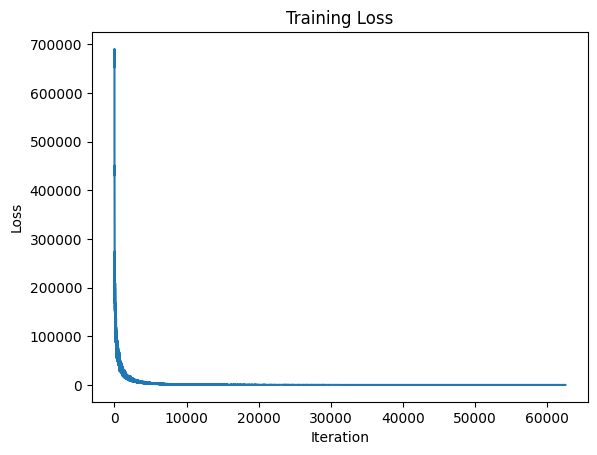

In [100]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [94]:
del w1, b1, w2, b2, x_train, y_train_onehot, y_pred, loss, dy_pred, dhidden, dw2, db2, dw1, db1
gc.collect()
torch.cuda.empty_cache()

In [95]:
class NeuralNetwork(nn.Module):
    def __init__(self, Din, H, Dout):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(Din, H)
        self.linear2 = nn.Linear(H, Dout)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [96]:
model = NeuralNetwork(Din, 100, K).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

In [97]:
for t in range(iterations):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1).to(device)  # Flatten input to (Ntr, Din)
        y_train = labels.to(device)  # Convert labels to one-hot

        # Forward pass
        y_pred = model(x_train)

        # Loss calculation
        loss_val = loss(y_pred, y_train)
        loss_history.append(loss_val.item())
        running_loss += loss_val.item()

        # Backpropagation
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

Epoch 1 / 20, Loss: 2.2807698350492687
Epoch 2 / 20, Loss: 2.2425860518152256
Epoch 3 / 20, Loss: 2.2104493619841943
Epoch 4 / 20, Loss: 2.182940593379015
Epoch 5 / 20, Loss: 2.158985457508822
Epoch 6 / 20, Loss: 2.13791190151671
Epoch 7 / 20, Loss: 2.1188997469570725
Epoch 8 / 20, Loss: 2.101820018988577
Epoch 9 / 20, Loss: 2.086154648606318
Epoch 10 / 20, Loss: 2.0718728535006004
Epoch 11 / 20, Loss: 2.0586741184928976
Epoch 12 / 20, Loss: 2.046439448992411
Epoch 13 / 20, Loss: 2.035057784652222
Epoch 14 / 20, Loss: 2.0244388838113307
Epoch 15 / 20, Loss: 2.0144163315981074
Epoch 16 / 20, Loss: 2.0049448403805705
Epoch 17 / 20, Loss: 1.9960403527804695
Epoch 18 / 20, Loss: 1.9875921377064856
Epoch 19 / 20, Loss: 1.9794436523110457
Epoch 20 / 20, Loss: 1.971827177077017


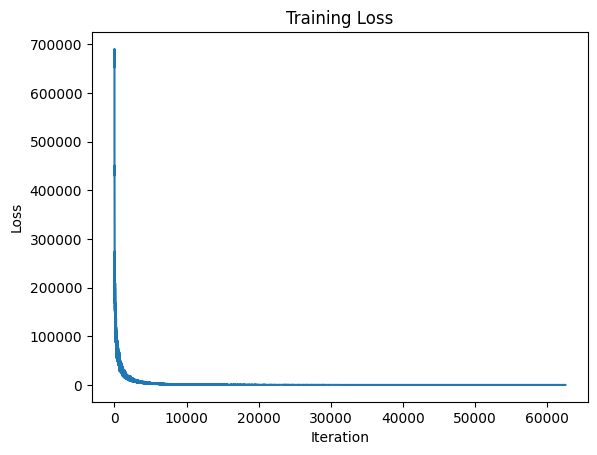

In [101]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [103]:
accuracy = 0
model.eval()
with  torch.inference_mode():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        x_test, y_test = inputs.to(device), labels.to(device)
        Ntr = inputs.shape[0]
        x_test = inputs.view(Ntr, -1).to(device)
        y_pred = model(x_test)
        _, predicted = torch.max(y_pred, 1)
        accuracy += (predicted == y_test).sum().item()

print(f"Accuracy: {accuracy / len(testset)}")

Accuracy: 0.3265


### LeNet-5

Here we will be implementint LeNet-5 architecture for MNIST dataset.

In [ ]:
batch_size = 32

In [6]:
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, shuffle=True)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size, shuffle=False)
classes = tuple(str(i) for i in range(10))

In [7]:
class LeNet(nn.Module):
    def __init__(self, input_size, input_channels, output_size):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        conv_output_size = ((input_size - 4) // 2 - 4) // 2
        self.classifier = nn.Sequential(
            nn.Linear(16 * conv_output_size * conv_output_size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_size)
        )

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = y.view(y.size(0), -1)
        y = self.classifier(y)
        return y

In [8]:
lenet_model = LeNet(input_size = 28, input_channels = 1, output_size = 10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
iterations = 10

We will define a function for training and testing the model so that it can be reused.

In [ ]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [ ]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(lenet_model, trainloader_mnist, testloader_mnist, iterations, optimizer, loss, device)

Epoch 1 / 10, Train Loss: 0.0676766942855902, Test Loss: 0.04813629430419313, Train Accuracy: 0.9793, Test Accuracy: 0.9842
Epoch 2 / 10, Train Loss: 0.049632370625242284, Test Loss: 0.03429339679422092, Train Accuracy: 0.9847, Test Accuracy: 0.9891
Epoch 3 / 10, Train Loss: 0.0393327897625432, Test Loss: 0.03513272591387682, Train Accuracy: 0.9877333333333334, Test Accuracy: 0.9886
Epoch 4 / 10, Train Loss: 0.03353311094713087, Test Loss: 0.03051077560371959, Train Accuracy: 0.9895, Test Accuracy: 0.9902
Epoch 5 / 10, Train Loss: 0.02692511745147834, Test Loss: 0.03761064433375561, Train Accuracy: 0.9916, Test Accuracy: 0.9877
Epoch 6 / 10, Train Loss: 0.023537788599048023, Test Loss: 0.032220297924741084, Train Accuracy: 0.9922, Test Accuracy: 0.99
Epoch 7 / 10, Train Loss: 0.02082437977665977, Test Loss: 0.03686231390548955, Train Accuracy: 0.9932833333333333, Test Accuracy: 0.9885
Epoch 8 / 10, Train Loss: 0.01770103432736408, Test Loss: 0.03382790025579925, Train Accuracy: 0.99425

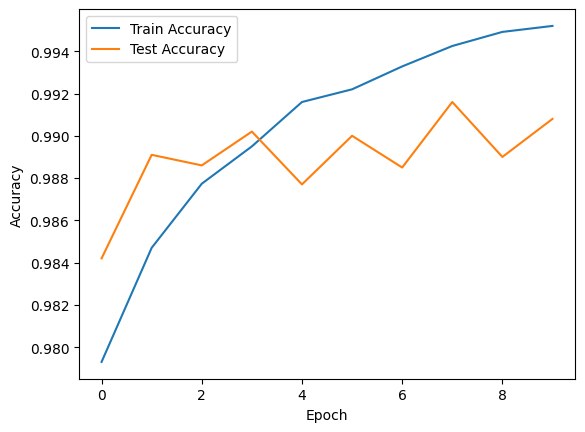

In [16]:
plt.plot(train_accuracy_hist, label='Train Accuracy')
plt.plot(test_accuracy_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

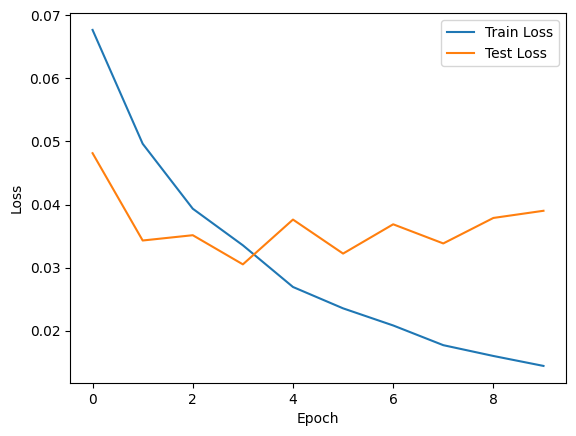

In [17]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Observing the plots of loss and accuracy, we can see that the model is performing well. As expected, the train and test losses are decreasing and the train and test accuracies are increasing with each epoch. After 10 epochs, the model was able to achieve a test accuracy of $99.08\%$. This is easy to achieve as the MNIST dataset is simple and LeNet-5 is a good architecture for this dataset.

### Implementing ResNet-18

In this section, we will implement ResNet-18 architecture for classifying the hymenoptera dataset consiting of images of ants and bees. In this first section, we will be finetuning the netwrok where we will be using a pre-trained model and retraining it on the hymenoptera dataset. In the second section, we will be using the network as a feature extractor where we freeze the weights of the network and only train the final classification layer.

#### Finetuning the network

In [18]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # These are the default weights
data_folder = './data/hymenoptera_data'
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainset_hymenoptera = torchvision.datasets.ImageFolder(root=f'{data_folder}/train', transform=train_transforms)
trainloader_hymenoptera = torch.utils.data.DataLoader(trainset_hymenoptera, batch_size=batch_size, shuffle=True)
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
testset_hymenoptera = torchvision.datasets.ImageFolder(root=f'{data_folder}/val', transform=test_transforms)
testloader_hymenoptera = torch.utils.data.DataLoader(testset_hymenoptera, batch_size=batch_size, shuffle=False)
classes_hymenoptera = trainset_hymenoptera.classes

In [19]:
print(summary(resnet_model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    │ 

In [20]:
resnet_model.fc = nn.Linear(512, len(classes_hymenoptera)).to(device)

In [21]:
print(summary(resnet_model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 2]                   --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    │ 

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001)
iterations = 15

In [ ]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, trainloader_hymenoptera, testloader_hymenoptera, iterations, optimizer, loss, device)

Epoch 1 / 15, Train Loss: 0.7804588004946709, Test Loss: 0.7100486338138581, Train Accuracy: 0.46311475409836067, Test Accuracy: 0.5686274509803921
Epoch 2 / 15, Train Loss: 0.6813012287020683, Test Loss: 0.6556009531021119, Train Accuracy: 0.5737704918032787, Test Accuracy: 0.5882352941176471
Epoch 3 / 15, Train Loss: 0.6481982618570328, Test Loss: 0.6079144477844238, Train Accuracy: 0.6024590163934426, Test Accuracy: 0.6405228758169934
Epoch 4 / 15, Train Loss: 0.5794674605131149, Test Loss: 0.5647582888603211, Train Accuracy: 0.680327868852459, Test Accuracy: 0.7058823529411765
Epoch 5 / 15, Train Loss: 0.5641244500875473, Test Loss: 0.5319272816181183, Train Accuracy: 0.7213114754098361, Test Accuracy: 0.7516339869281046
Epoch 6 / 15, Train Loss: 0.5117188058793545, Test Loss: 0.5040961265563965, Train Accuracy: 0.7745901639344263, Test Accuracy: 0.7712418300653595
Epoch 7 / 15, Train Loss: 0.5000193938612938, Test Loss: 0.47229596972465515, Train Accuracy: 0.7950819672131147, Test

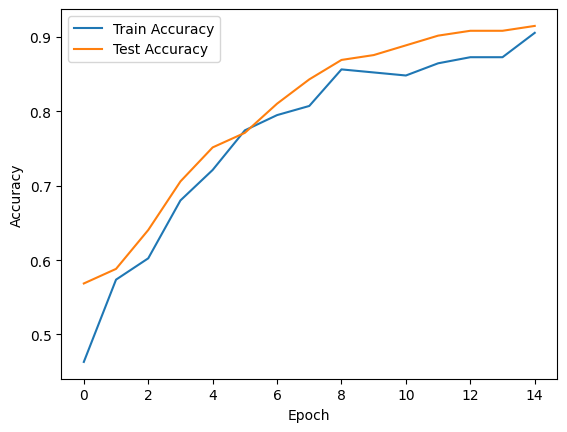

In [24]:
plt.plot(train_accuracy_hist, label='Train Accuracy')
plt.plot(test_accuracy_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

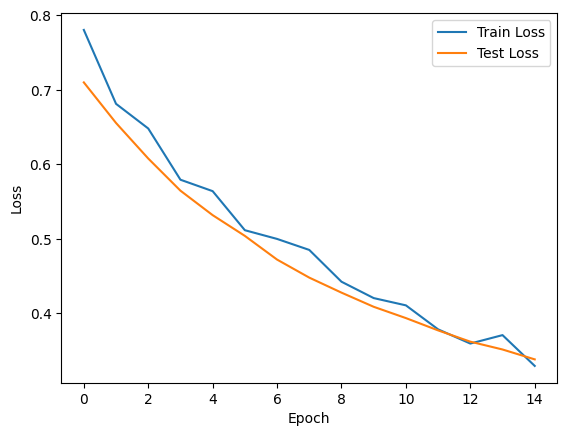

In [25]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can observe the model to be performing well as the train and test losses are decreasing and the train and test accuracies are increasing with each epoch. After 25 epochs, the model was able to achieve a test accuracy of $91.50\%$.

#### Using ResNet-18 as a feature extractor

In [26]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # We need to reobtain the model as we have modified it previously
resnet_model.fc = nn.Linear(512, len(classes)).to(device)
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [27]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001)

In [28]:
print(summary(resnet_model, input_size=(batch_size, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 10]                  --                        Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        False
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        False


In [ ]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, trainloader_hymenoptera, testloader_hymenoptera, iterations, optimizer, loss, device)

Epoch 1 / 15, Train Loss: 2.0300609469413757, Test Loss: 1.3959161281585692, Train Accuracy: 0.3237704918032787, Test Accuracy: 0.6143790849673203
Epoch 2 / 15, Train Loss: 1.2621418982744217, Test Loss: 1.0441188573837281, Train Accuracy: 0.6598360655737705, Test Accuracy: 0.6993464052287581
Epoch 3 / 15, Train Loss: 0.9847868233919144, Test Loss: 0.8640852093696594, Train Accuracy: 0.6721311475409836, Test Accuracy: 0.7124183006535948
Epoch 4 / 15, Train Loss: 0.834665983915329, Test Loss: 0.7645793199539185, Train Accuracy: 0.7008196721311475, Test Accuracy: 0.6928104575163399
Epoch 5 / 15, Train Loss: 0.73829635232687, Test Loss: 0.6947847723960876, Train Accuracy: 0.7213114754098361, Test Accuracy: 0.7516339869281046
Epoch 6 / 15, Train Loss: 0.6788754910230637, Test Loss: 0.6403049468994141, Train Accuracy: 0.7868852459016393, Test Accuracy: 0.8104575163398693
Epoch 7 / 15, Train Loss: 0.6286270618438721, Test Loss: 0.5994332015514374, Train Accuracy: 0.7827868852459017, Test Acc

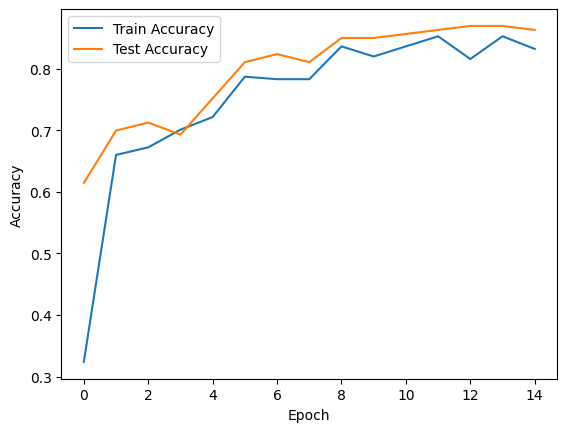

In [30]:
plt.plot(train_accuracy_hist, label='Train Accuracy')
plt.plot(test_accuracy_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

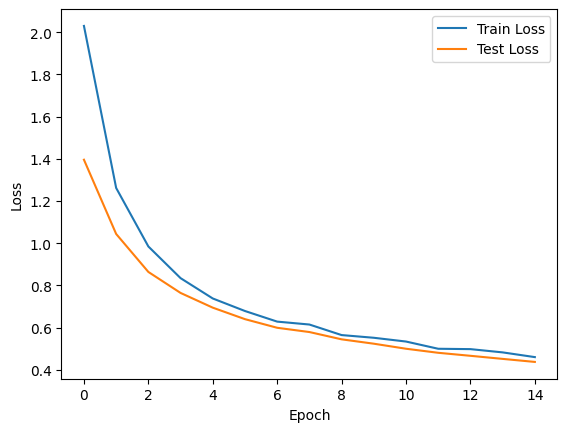

In [31]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

When using the model as a feature extractor, the performance is as expected however, it is less than when the model was finetuned. This is because the weights of the network are frozen and only the final classification layer is trained. After 10 epochs, the model was able to achieve a test accuracy of $86.02\%$.